Data generated with PhaseDiagramMultpileResonance.py

In [3]:
import tensorflow as tf
from functionsTF import *
from functions import *
from IO import *

%load_ext autoreload
%autoreload 2

import time
import numpy as np
import matplotlib
%matplotlib inline
import pylab as plt
import seaborn as sns
#Imports for visualization
import PIL.Image
from io import BytesIO
from IPython.display import clear_output, Image, display

In [4]:
import mutual_info

In [5]:
N = 100
T = 500

DEVICE = '/gpu:0'

In [20]:
scaling = 1 / (1 / (2 * 2 / 0.25)) ** 0.5 * 70
def generateInput2(seed, T, n=None):
    dt = 0.25
    np.random.seed(seed)
    x = np.linspace(0.0, dt*T, T)
    signal = np.zeros(len(x))
    iBack = 0
    for i in range(len(x)):
        iBack = iBack + dt / 10 * (-iBack + np.random.rand()-0.5)
        iEff = iBack * scaling +  20
        signal[i] = iEff
    return signal/np.max(signal)

(0, 1000)

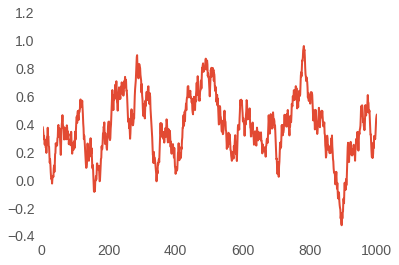

In [21]:
plt.plot(generateInput2(2, T))
plt.xlim([0,1000])

In [11]:
disp = False
tauv = 15
sG = 0
N = 100
T= 500

### input 1: apple
gpu = TfSingleNet(N=N,T=T, disp=disp, tauv=tauv, device=DEVICE, g0=10, startPlast=4000, NUM_CORES=1)
gpu.spikeMonitor = True
apple = generateInput2(2, T)
gpu.input = apple/np.max(apple)*1*0
gpu.input = np.ones(len(apple))*4
gpu.input = generateInput2(2, T) * 20
gpu.runTFSimul()
apple_out = gpu.vvm[-1000:]

1.52


4.95032556355


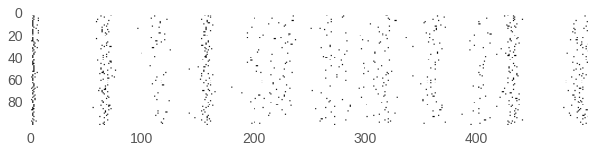

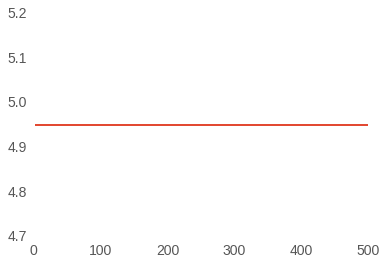

In [12]:
plt.figure(figsize=(10,10))
plt.imshow(gpu.raster.transpose())
plt.savefig(DIRECTORY + 'raster-N_%d-sg_%d-tauv_%d.png'%( N, sG, tauv))
plt.figure()
plt.plot(gpu.gamma)
print(np.mean(gpu.gamma))

In [17]:
plt.plot(gpu.input)

NameError: name 'gpu' is not defined

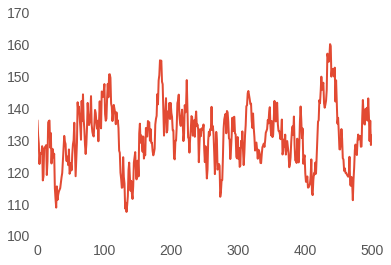

In [14]:
plt.plot(np.mean(gpu.iEff, axis=1))

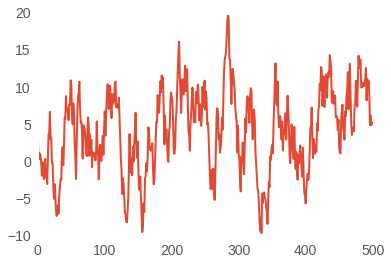

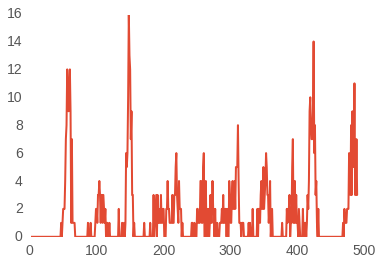

In [15]:
plt.plot(gpu.input)
plt.figure()
plt.plot(gpu.vvm[10:1000])

In [12]:
fourier(np.array(gpu.vvm[100:]))

[59.405940594059409, -15.629834992334292]

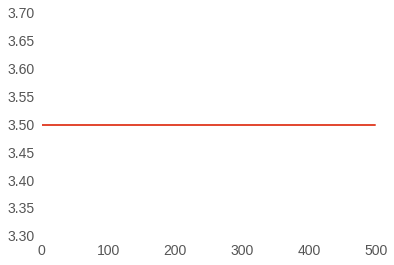

In [10]:
plt.plot(gpu.gamma)

In [10]:
'''
Read the data file and compile them into a pandas dataframe 
'''
df = pd.DataFrame(columns=('tauv', 'g', 'k', 'T', 'N', 'freq', 'power') )
d = 500
i=-1
sigma = 1
for T in [4000]:
    for k in range(0,50,5):
        for N in [100]:
            for g in np.arange(0,20,2):
                for tauv in np.arange(15,90,5):
                    i+=1
                    filename = "../data/PhasePlan3/PhasePlan3-tauv-%d_g-%d_N-%d_T-%d_k-%d" % (tauv, g, N, T, k)
                    a = np.load(filename)
                    df.loc[i] = [int(tauv), int(g), int(k), int(T), int(N), 
                                a['freq'], a['power']]

In [11]:
def facet_heatmap(data, df=None, v=0, vmin=None, vmax=None, **kws):
    kind = data['variable'].get_values()[0][:-1]
    if vmin == None:
        vmin, _ = vmin_vmax(df, kind=kind, v=v)
    if vmax == None:
        _, vmax = vmin_vmax(df, kind=kind, v=v)
    data = data.pivot(index='k', columns='g', values='value')
    im = sns.heatmap(data, yticklabels=10, xticklabels=10, vmin=vmin, vmax=vmax, **kws)  # <-- Pass kwargs to heatmap
    im.invert_yaxis()
    
def plotGridHeatmap(df, col_wrap=2, cols=['burst1', 'spike1', 'burst2', 'spike2'], v=-1, vmin=None, vmax=None, **kws):
    data = pd.melt(df, id_vars=['k', 'g'], value_vars=cols)
    #     print(data.head())
    with sns.plotting_context(font_scale=5.5):
        g = sns.FacetGrid(data, col="variable", col_wrap=col_wrap, size=3, aspect=1)

    cbar_ax = g.fig.add_axes([.92, .3, .02, .4])  # <-- Create a colorbar axes
    g = g.map_dataframe(facet_heatmap, v=v, df=df, vmin=vmin, vmax=vmax,
                        cbar_ax=cbar_ax, **kws)  # <-- Specify the colorbar axes and limits
    g.set_titles(col_template="{col_name}", fontweight='bold', fontsize=18)
    g.fig.subplots_adjust(right=.9)  # <-- Add space so the colorbar doesn't overlap the plot
    return g

def plotHeatmap(df, col="cor1", title='', cmap=None, **kws):
    plt.figure()
    '''
    plot heatmap using seaborn library
    '''
    burst = df[['k', 'g', col]]
    burst.loc[:, (col)] = burst[col].astype(float)
    burst.loc[:,('k')] = burst['k'].astype(int)
    burst.loc[:,('g')] = burst['g'].astype(int)
    c = burst.pivot('k','g', col)


    im = sns.heatmap(c, yticklabels=5, xticklabels=2, cmap=cmap, **kws)
    im.invert_yaxis()
    sns.set_style("whitegrid")
    if not title:
        title=col
    plt.title(title)
    return 0

In [12]:
# df = df.fillna(0)
# for tauv in np.arange(15,90,5):
#     df2 = df[(df['tauv']==tauv) & (df['k']>0)]
#     # plotGridHeatmap(df2, cols=['freq', 'power'])
#     plotHeatmap(df2, col='freq', vmin=0, vmax=50)
#     plotHeatmap(df2, col='power', vmin=-15, vmax=0)

/mnt/DATA/gp1514/.pyenv/versions/anaconda3-4.1.0/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


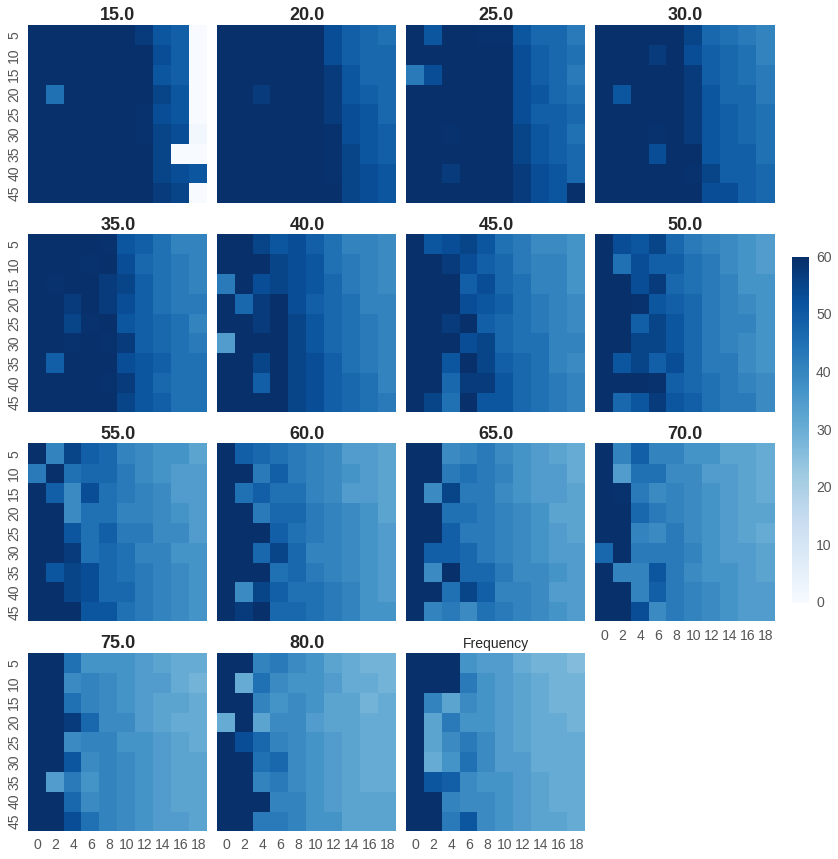

In [15]:
df2 = df[(df['k']>0)]
# data = df2.sort_values('k')
data = df2
col = 'freq'
df2.loc[:, (col)] = df2[col].astype(float)
df2.loc[:,('k')] = df2['k'].astype(int)
df2.loc[:,('g')] = df2['g'].astype(int)

def facet_heatmap(data, color, **kws):
    data = data.pivot(index="k", columns='g', values=col)
    sns.heatmap(data, cmap='Blues', **kws)  # <-- Pass kwargs to heatmap

with sns.plotting_context(font_scale=5.5):
    g = sns.FacetGrid(data, col="tauv", col_wrap=4, size=3, aspect=1)

cbar_ax = g.fig.add_axes([.92, .3, .02, .4])

g = g.map_dataframe(facet_heatmap,
                    cbar_ax=cbar_ax,
                    vmin=0, vmax=60) 

g.set_titles(col_template="{col_name}", fontweight='bold', fontsize=18)
g.fig.subplots_adjust(right=.9)
plt.title('Frequency')
plt.savefig(DIRECTORY + 'phaseplan-frequency.pdf')

/mnt/DATA/gp1514/.pyenv/versions/anaconda3-4.1.0/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


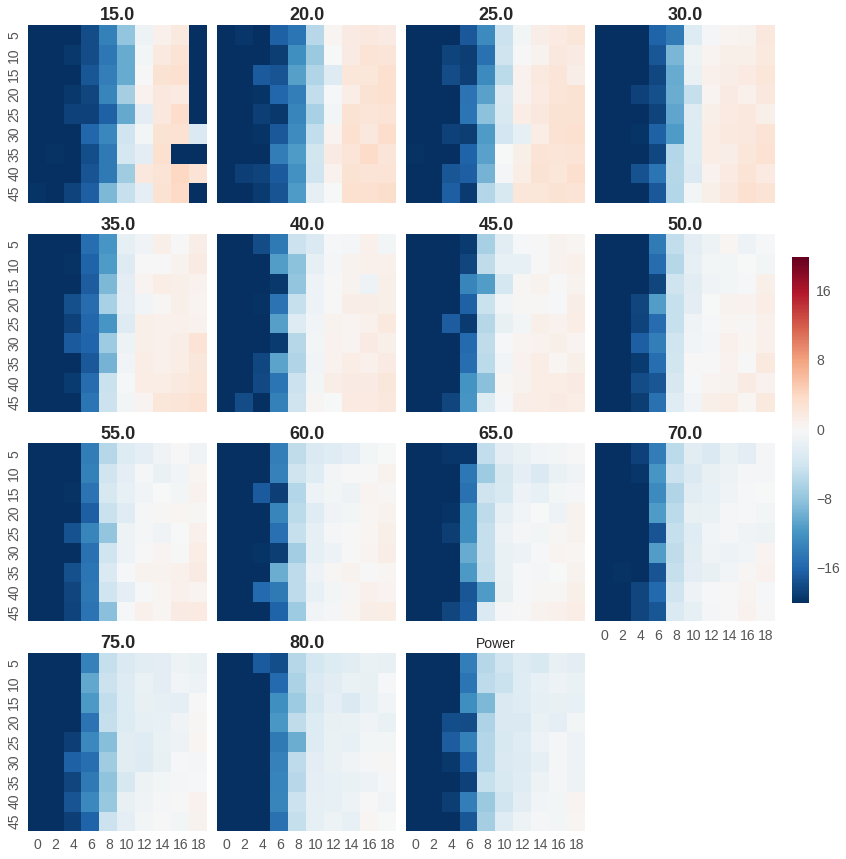

In [16]:
df2 = df[(df['k']>0)]
# data = df2.sort_values('k')
data = df2
col = 'power'
df2.loc[:, (col)] = df2[col].astype(float)
df2.loc[:,('k')] = df2['k'].astype(int)
df2.loc[:,('g')] = df2['g'].astype(int)

def facet_heatmap(data, color, **kws):
    data = data.pivot(index="k", columns='g', values=col)
    sns.heatmap(data, cmap='RdBu_r', **kws)  # <-- Pass kwargs to heatmap

with sns.plotting_context(font_scale=5.5):
    g = sns.FacetGrid(data, col="tauv", col_wrap=4, size=3, aspect=1)

cbar_ax = g.fig.add_axes([.92, .3, .02, .4])

g = g.map_dataframe(facet_heatmap,
                    cbar_ax=cbar_ax,
                    vmin=-15, vmax=20) 

g.set_titles(col_template="{col_name}", fontweight='bold', fontsize=18)
g.fig.subplots_adjust(right=.9)
plt.title('Power')
plt.savefig(DIRECTORY + 'phaseplan-power.pdf')